# Predicting-Indian-Stock-Options-LSTM-vs.-Black-Scholes


In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install scipy

In [1]:
import pandas as pd
from functools import reduce
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import Dropout
from scipy.stats import norm
from keras.regularizers import l2
from sklearn.model_selection import train_test_split


## EDA

In [2]:
df = pd.read_csv('3mfanddo.csv')
df.head()

,Unnamed: 0,INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,OPEN,HIGH,LOW,CLOSE,SETTLE_PR,CONTRACTS,VAL_INLAKH,OPEN_INT,CHG_IN_OI,TIMESTAMP
0,160393,FUTIDX,BANKNIFTY,29-Aug-2019,0.0,XX,28805.65,28924.00,28140.55,28499.30,28499.30,214569.0,1225914.96,1675780.0,234640.0,01-AUG-2019
1,160394,FUTIDX,BANKNIFTY,26-Sep-2019,0.0,XX,28926.40,29030.55,28251.70,28611.45,28611.45,2484.0,14245.95,51400.0,-80.0,01-AUG-2019
2,160395,FUTIDX,BANKNIFTY,31-Oct-2019,0.0,XX,29000.00,29105.00,28355.55,28699.05,28699.05,598.0,3434.43,9460.0,4860.0,01-AUG-2019
3,160396,FUTIDX,NIFTY,29-Aug-2019,0.0,XX,11098.40,11098.40,10901.10,11015.35,11015.35,199881.0,1650955.24,19001400.0,1339200.0,01-AUG-2019
4,160397,FUTIDX,NIFTY,26-Sep-2019,0.0,XX,11136.35,11145.20,10955.00,11066.60,11066.60,5283.0,43841.57,893625.0,66750.0,01-AUG-2019


In [138]:
df = df[df['STRIKE_PR'] != 0]
df['EXPIRY_DT'] = pd.to_datetime(df['EXPIRY_DT'], format='%d-%b-%Y')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%d-%b-%Y')
df['DAYS_TO_EXPIRY'] = (df['EXPIRY_DT'] - df['TIMESTAMP']).dt.days

unique_option_types = df['OPTION_TYP'].unique()
unique_instruments = df['INSTRUMENT'].unique()
unique_instruments

array(['OPTIDX', 'OPTSTK'], dtype=object)

In [248]:
call_options_df = df[df['OPTION_TYP'] == 'CE'].dropna()
call_options_df['DAILY_RETURNS'] = call_options_df.groupby('SYMBOL')['CLOSE'].pct_change()
average_volatility_call = call_options_df.groupby('SYMBOL')['DAILY_RETURNS'].std() * np.sqrt(252) / 100
average_volatility_dict = average_volatility_call.to_dict()
call_options_df['AVERAGE_VOLATILITY'] = call_options_df['SYMBOL'].map(average_volatility_dict)
call_options_df.tail()

,Unnamed: 0,INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,OPEN,HIGH,LOW,CLOSE,SETTLE_PR,CONTRACTS,VAL_INLAKH,OPEN_INT,CHG_IN_OI,TIMESTAMP,DAYS_TO_EXPIRY,DAILY_RETURNS,AVERAGE_VOLATILITY
2533177,32769905,OPTSTK,ZEEL,2019-12-26,390.0,CE,0.0,0.0,0.0,14.35,5.90,0.0,0.0,0.0,0.0,2019-10-31,56,-0.103125,9.370202
2533178,32769906,OPTSTK,ZEEL,2019-12-26,400.0,CE,0.0,0.0,0.0,12.80,5.10,0.0,0.0,0.0,0.0,2019-10-31,56,-0.108014,9.370202
2533179,32769907,OPTSTK,ZEEL,2019-12-26,410.0,CE,0.0,0.0,0.0,11.45,4.40,0.0,0.0,0.0,0.0,2019-10-31,56,-0.105469,9.370202
2533180,32769908,OPTSTK,ZEEL,2019-12-26,420.0,CE,0.0,0.0,0.0,10.25,3.80,0.0,0.0,0.0,0.0,2019-10-31,56,-0.104803,9.370202
2533181,32769909,OPTSTK,ZEEL,2019-12-26,430.0,CE,0.0,0.0,0.0,9.15,3.25,0.0,0.0,0.0,0.0,2019-10-31,56,-0.107317,9.370202


In [249]:
put_options_df = df[df['OPTION_TYP'] == 'PE'].dropna()
put_options_df['DAILY_RETURNS'] = put_options_df.groupby('SYMBOL')['CLOSE'].pct_change()
average_volatility_put = put_options_df.groupby('SYMBOL')['DAILY_RETURNS'].std() * np.sqrt(252) / 100
average_volatility_dict_put = average_volatility_put.to_dict()
put_options_df['AVERAGE_VOLATILITY'] = put_options_df['SYMBOL'].map(average_volatility_dict_put)
put_options_df.tail()

,Unnamed: 0,INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,OPEN,HIGH,LOW,CLOSE,SETTLE_PR,CONTRACTS,VAL_INLAKH,OPEN_INT,CHG_IN_OI,TIMESTAMP,DAYS_TO_EXPIRY,DAILY_RETURNS,AVERAGE_VOLATILITY
2533205,32769933,OPTSTK,ZEEL,2019-12-26,390.0,PE,0.0,0.0,0.0,111.70,131.75,0.0,0.0,0.0,0.0,2019-10-31,56,0.078706,6.433942
2533206,32769934,OPTSTK,ZEEL,2019-12-26,400.0,PE,0.0,0.0,0.0,120.00,140.90,0.0,0.0,0.0,0.0,2019-10-31,56,0.074306,6.433942
2533207,32769935,OPTSTK,ZEEL,2019-12-26,410.0,PE,0.0,0.0,0.0,128.50,150.10,0.0,0.0,0.0,0.0,2019-10-31,56,0.070833,6.433942
2533208,32769936,OPTSTK,ZEEL,2019-12-26,420.0,PE,0.0,0.0,0.0,137.15,159.40,0.0,0.0,0.0,0.0,2019-10-31,56,0.067315,6.433942
2533209,32769937,OPTSTK,ZEEL,2019-12-26,430.0,PE,0.0,0.0,0.0,145.90,168.80,0.0,0.0,0.0,0.0,2019-10-31,56,0.063799,6.433942


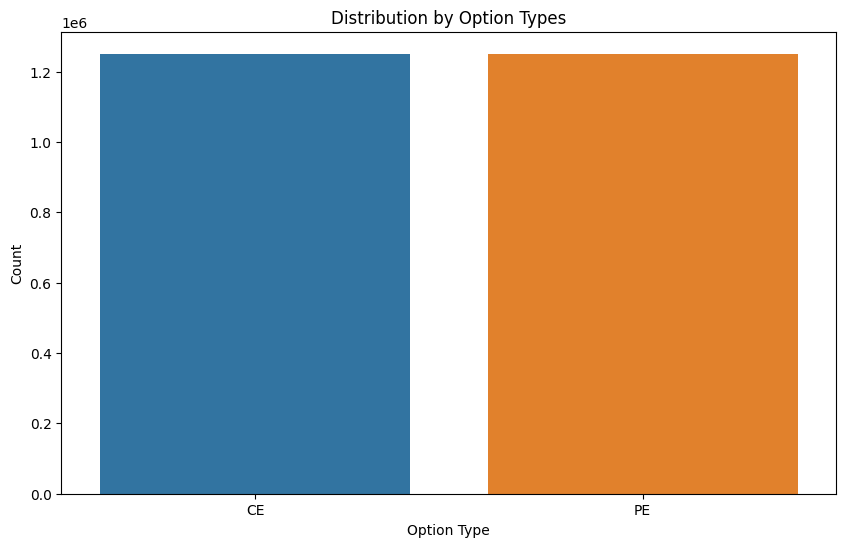

In [109]:
# Distribution by Option Types (Bar Chart)
plt.figure(figsize=(10, 6))
sns.countplot(x='OPTION_TYP', data=df)
plt.title('Distribution by Option Types')
plt.ylabel('Count')
plt.xlabel('Option Type')
plt.show()

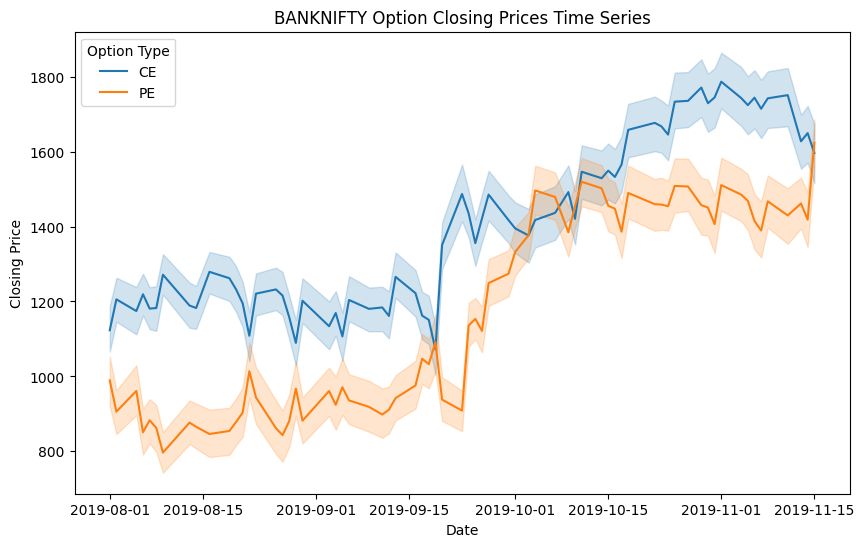

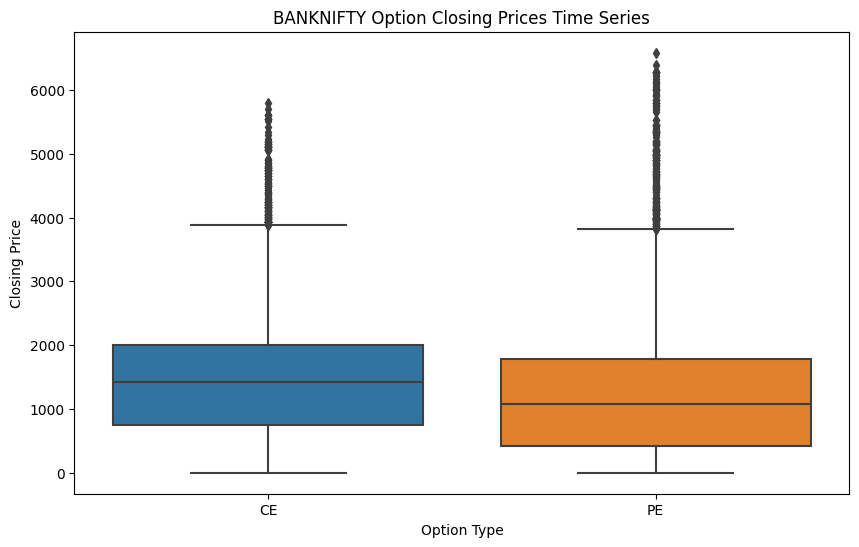

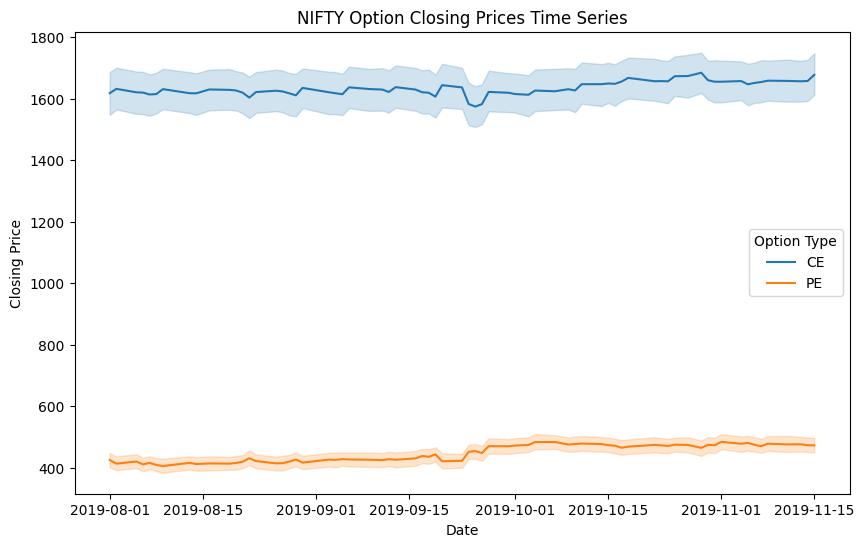

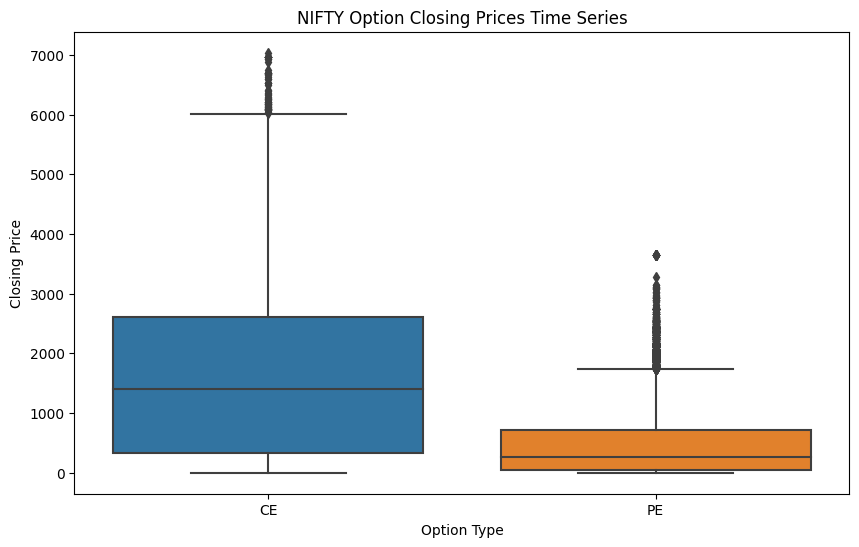

In [110]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
selected_symbols = ['BANKNIFTY', 'NIFTY']  
for symbol in selected_symbols:
    symbol_df = df[df['SYMBOL'] == symbol]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='TIMESTAMP', y='CLOSE', hue='OPTION_TYP', data=symbol_df)
    plt.title(f'{symbol} Option Closing Prices Time Series')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(title='Option Type')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='OPTION_TYP', y='CLOSE', data=symbol_df)
    plt.title(f'{symbol} Option Closing Prices Time Series')
    plt.xlabel('Option Type')
    plt.ylabel('Closing Price')
    plt.show()

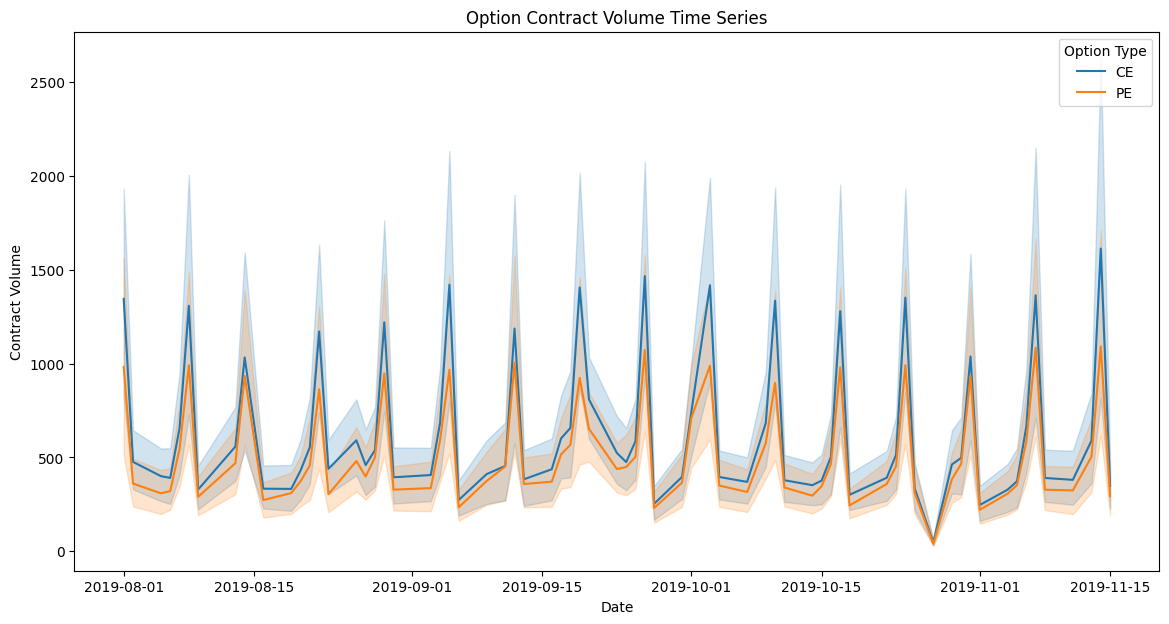

In [111]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='TIMESTAMP', y='CONTRACTS', hue='OPTION_TYP', data=df)
plt.title('Option Contract Volume Time Series')
plt.xlabel('Date')
plt.ylabel('Contract Volume')
plt.legend(title='Option Type')
plt.show()

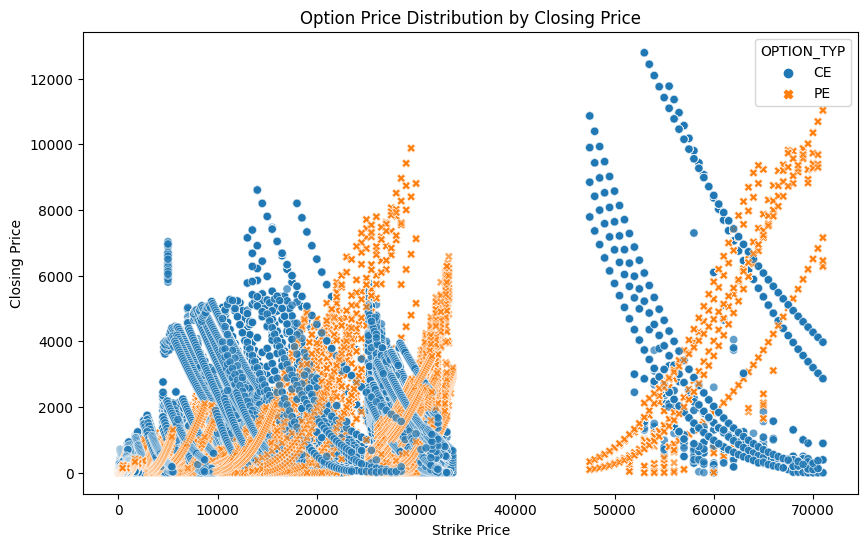

In [244]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='STRIKE_PR', y='CLOSE', hue='OPTION_TYP', data=df, style='OPTION_TYP', alpha=0.7)
plt.title('Option Price Distribution by Closing Price')
plt.xlabel('Strike Price')
plt.ylabel('Closing Price')
plt.show()

## Model Training

### FOR CALL OPTION

In [204]:
# NaN value drop
call_options_df.dropna(inplace=True)

# Selecting the 'CLOSE' column as the target variable for option prices
X_call = call_options_df[['STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'OPEN_INT','DAYS_TO_EXPIRY','AVERAGE_VOLATILITY']]  # Inputs
y_call = call_options_df['CLOSE']  # Target

In [205]:
print("Any NaN in the predictions?", np.isnan(X_call).any())
print("Any NaN in the predictions?", np.isnan(y_call).any())

Any NaN in the predictions? STRIKE_PR             False
OPEN                  False
HIGH                  False
LOW                   False
OPEN_INT              False
DAYS_TO_EXPIRY        False
AVERAGE_VOLATILITY    False
dtype: bool
Any NaN in the predictions? False


In [206]:
# Scaling data
scaler_call = MinMaxScaler(feature_range=(0, 1))
X_scaled_call = scaler_call.fit_transform(X_call)
y_scaled_call = scaler_call.fit_transform(y_call.values.reshape(-1,1))

# Split into training and test sets
X_train_call, X_test_call, y_train_call, y_test_call, train_index, test_index = train_test_split(
    X_scaled_call, y_scaled_call, np.arange(len(X_scaled_call)), test_size=0.15, random_state=42)

# Data reshaping for LSTM
X_train_call = X_train_call.reshape((X_train_call.shape[0], 1, X_train_call.shape[1]))
X_test_call = X_test_call.reshape((X_test_call.shape[0], 1, X_test_call.shape[1]))

In [207]:
model_call = Sequential()
model_call.add(LSTM(50, activation='relu', input_shape=(X_train_call.shape[1], X_train_call.shape[2])))
model_call.add(Dropout(0.2))
model_call.add(Dense(1))
model_call.compile(optimizer='adam', loss='mse')

In [208]:
history_call = model_call.fit(
    X_train_call, y_train_call, 
    epochs=30, 
    batch_size=32, 
    validation_data=(X_test_call, y_test_call), 
    verbose=2, 
)

Epoch 1/30
33216/33216 - 32s - loss: 0.0015 - val_loss: 0.0012 - 32s/epoch - 970us/step
Epoch 2/30
33216/33216 - 31s - loss: 0.0013 - val_loss: 0.0011 - 31s/epoch - 926us/step
Epoch 3/30
33216/33216 - 31s - loss: 0.0012 - val_loss: 0.0011 - 31s/epoch - 937us/step
Epoch 4/30
33216/33216 - 31s - loss: 0.0012 - val_loss: 0.0011 - 31s/epoch - 921us/step
Epoch 5/30
33216/33216 - 31s - loss: 0.0011 - val_loss: 0.0010 - 31s/epoch - 942us/step
Epoch 6/30
33216/33216 - 31s - loss: 0.0011 - val_loss: 0.0010 - 31s/epoch - 919us/step
Epoch 7/30
33216/33216 - 30s - loss: 0.0011 - val_loss: 9.5590e-04 - 30s/epoch - 917us/step
Epoch 8/30
33216/33216 - 31s - loss: 0.0011 - val_loss: 9.5562e-04 - 31s/epoch - 921us/step
Epoch 9/30
33216/33216 - 30s - loss: 0.0011 - val_loss: 9.7146e-04 - 30s/epoch - 897us/step
Epoch 10/30
33216/33216 - 30s - loss: 0.0011 - val_loss: 9.2846e-04 - 30s/epoch - 906us/step
Epoch 11/30
33216/33216 - 30s - loss: 0.0011 - val_loss: 9.3905e-04 - 30s/epoch - 895us/step
Epoch 12/3

In [209]:
model_call.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                11600     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


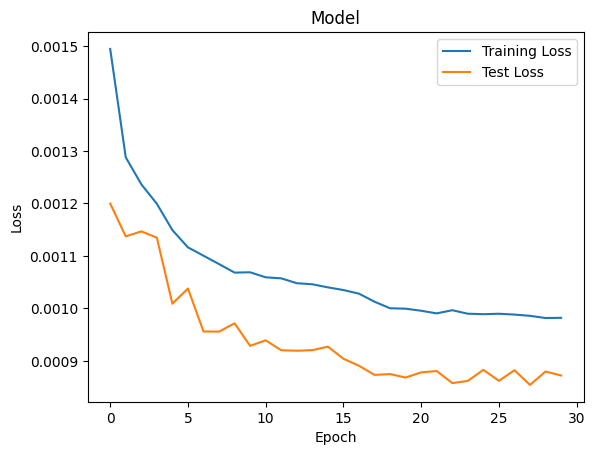

In [247]:
plt.plot(history_call.history['loss'], label='Training Loss')
plt.plot(history_call.history['val_loss'], label='Test Loss')
plt.title('Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [211]:
model_call.save('call_option_model.keras')

In [212]:
# Get predictions
y_pred_call_scaled = model_call.predict(X_test_call)

# Calculate error metrics
mse = mean_squared_error(y_test_call, y_pred_call_scaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_call, y_pred_call_scaled)

print(f"MSE: {mse}, RMSE: {rmse}, R^2: {r2}")

5862/5862 [==============================] - 3s 570us/step
MSE: 0.0008719362247689626, RMSE: 0.029528566249802286, R^2: 0.8122922629908359


In [213]:
y_pred_call = scaler_call.inverse_transform(y_pred_call_scaled).flatten()

In [189]:
def black_scholes_call_prices(df, risk_free_rate):
    # Calculate the call option price using the Black-Scholes formula
    def black_scholes_call(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_price

    prices = []
    for index, row in df.iterrows():
        S = row['CLOSE']  
        K = row['STRIKE_PR']
        T = row['DAYS_TO_EXPIRY'] / 365.0  
        sigma = row['AVERAGE_VOLATILITY']  

        price = black_scholes_call(S, K, T, risk_free_rate, sigma)
        prices.append(price)

    return prices

In [191]:
bs_data = call_options_df[['STRIKE_PR', 'CLOSE', 'DAYS_TO_EXPIRY', 'AVERAGE_VOLATILITY']].copy()
bs_call_prices = black_scholes_call_prices(bs_data, 0.0675)
call_options_df['BS_Call_Prices'] = bs_call_prices


C:\Users\eren\AppData\Local\Temp\ipykernel_11616\2117132681.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\eren\AppData\Local\Temp\ipykernel_11616\2117132681.py:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [202]:
mse = mean_squared_error(call_options_df.dropna()['CLOSE'], call_options_df.dropna()['BS_Call_Prices'])
rmse = np.sqrt(mse)
r2 = r2_score(call_options_df.dropna()['CLOSE'], call_options_df.dropna()['BS_Call_Prices'])

print(f"MSE: {mse}, RMSE: {rmse}, R^2: {r2}")

MSE: 73423.47744298531, RMSE: 270.9676686303835, R^2: 0.9039037300737964


In [214]:
bs_call_prices = np.array(bs_call_prices)
comparison_df = pd.DataFrame({
    'Model_Predictions': y_pred_call,
    'BS_Call_Prices': bs_call_prices[test_index]  
})

comparison_df['Difference'] = comparison_df['Model_Predictions'] - comparison_df['BS_Call_Prices']


In [215]:
comparison_stats = comparison_df.describe()
comparison_stats

,Model_Predictions,BS_Call_Prices,Difference
count,187568.000000,187567.000000,187567.000000
mean,335.042877,295.092698,39.949656
std,744.618652,834.241480,866.286719
min,-425.017883,0.000000,-12769.405689
25%,38.187847,0.200581,-10.662749
50%,54.352621,11.602331,36.756865
75%,151.747742,109.337619,90.614387
max,10463.952148,12789.350000,10463.952148


### FOR PUT OPTION

In [216]:
put_options_df.dropna(inplace=True)

X_put = put_options_df[['STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'OPEN_INT','DAYS_TO_EXPIRY','AVERAGE_VOLATILITY']] 
y_put = put_options_df['CLOSE']  

In [217]:
print("Any NaN in the predictions?", np.isnan(X_put).any())
print("Any NaN in the predictions?", np.isnan(y_put).any())

Any NaN in the predictions? STRIKE_PR             False
OPEN                  False
HIGH                  False
LOW                   False
OPEN_INT              False
DAYS_TO_EXPIRY        False
AVERAGE_VOLATILITY    False
dtype: bool
Any NaN in the predictions? False


In [218]:
# Scaling data
scaler_put = MinMaxScaler(feature_range=(0, 1))
X_scaled_put = scaler_put.fit_transform(X_put)
y_scaled_put = scaler_put.fit_transform(y_put.values.reshape(-1,1))

# Split into training and test sets
X_train_put, X_test_put, y_train_put, y_test_put, train_index_put, test_index_put = train_test_split(
    X_scaled_put, y_scaled_put, np.arange(len(X_scaled_put)), test_size=0.15, random_state=42)

# Data reshaping for LSTM
X_train_put = X_train_put.reshape((X_train_put.shape[0], 1, X_train_put.shape[1]))
X_test_put = X_test_put.reshape((X_test_put.shape[0], 1, X_test_put.shape[1]))

In [219]:
model_put = Sequential()
model_put.add(LSTM(50, activation='relu', input_shape=(X_train_put.shape[1], X_train_put.shape[2])))
model_put.add(Dropout(0.2))
model_put.add(Dense(1))
model_put.compile(optimizer='adam', loss='mse')

In [220]:
history_put = model_put.fit(
    X_train_put, y_train_put, 
    epochs=30, 
    batch_size=32, 
    validation_data=(X_test_put, y_test_put), 
    verbose=2, 
)

Epoch 1/30
33216/33216 - 31s - loss: 0.0013 - val_loss: 0.0012 - 31s/epoch - 930us/step
Epoch 2/30
33216/33216 - 30s - loss: 0.0012 - val_loss: 0.0010 - 30s/epoch - 916us/step
Epoch 3/30
33216/33216 - 30s - loss: 0.0011 - val_loss: 9.6144e-04 - 30s/epoch - 911us/step
Epoch 4/30
33216/33216 - 30s - loss: 0.0010 - val_loss: 9.3508e-04 - 30s/epoch - 914us/step
Epoch 5/30
33216/33216 - 31s - loss: 9.4385e-04 - val_loss: 8.0904e-04 - 31s/epoch - 930us/step
Epoch 6/30
33216/33216 - 30s - loss: 8.8417e-04 - val_loss: 7.6156e-04 - 30s/epoch - 908us/step
Epoch 7/30
33216/33216 - 30s - loss: 8.4387e-04 - val_loss: 7.2568e-04 - 30s/epoch - 899us/step
Epoch 8/30
33216/33216 - 30s - loss: 7.9852e-04 - val_loss: 6.5753e-04 - 30s/epoch - 891us/step
Epoch 9/30
33216/33216 - 30s - loss: 7.5357e-04 - val_loss: 6.2661e-04 - 30s/epoch - 896us/step
Epoch 10/30
33216/33216 - 31s - loss: 7.2907e-04 - val_loss: 6.3150e-04 - 31s/epoch - 934us/step
Epoch 11/30
33216/33216 - 31s - loss: 7.1672e-04 - val_loss: 5.

In [221]:
model_put.save('put_option_model.keras')

In [222]:
model_put.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                11600     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


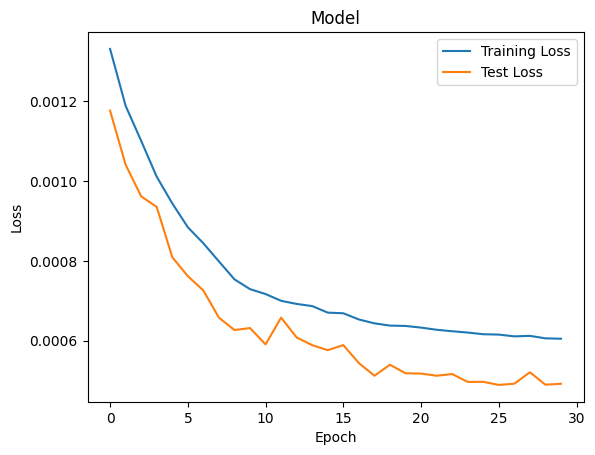

In [246]:
plt.plot(history_put.history['loss'], label='Training Loss')
plt.plot(history_put.history['val_loss'], label='Test Loss')
plt.title('Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [224]:
from sklearn.metrics import mean_squared_error, r2_score

# Get predictions
y_pred_put_scaled = model_call.predict(X_test_put)

# Calculate error metrics
mse = mean_squared_error(y_test_put, y_pred_put_scaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_put, y_pred_put_scaled)

print(f"MSE: {mse}, RMSE: {rmse}, R^2: {r2}")

5862/5862 [==============================] - 3s 572us/step
MSE: 0.022459949674512508, RMSE: 0.14986643945364322, R^2: -5.216288935828078


In [234]:
y_pred_put = scaler_call.inverse_transform(y_pred_put_scaled).flatten()


In [239]:
def black_scholes_put_prices(df, risk_free_rate):
    # Calculate the put option price using the Black-Scholes formula
    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return put_price

    prices = []
    for index, row in df.iterrows():
        S = row['CLOSE']  
        K = row['STRIKE_PR'] 
        T = row['DAYS_TO_EXPIRY'] / 365.0  
        sigma = row['AVERAGE_VOLATILITY']  

        price = black_scholes_put(S, K, T, risk_free_rate, sigma)
        prices.append(price)

    return prices


In [240]:
bs_data_put = put_options_df[['STRIKE_PR', 'CLOSE', 'DAYS_TO_EXPIRY', 'AVERAGE_VOLATILITY']].copy()
bs_put_prices = black_scholes_put_prices(bs_data_put, 0.0675)
put_options_df['BS_Put_Prices'] = bs_put_prices

C:\Users\eren\AppData\Local\Temp\ipykernel_11616\2477557456.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [241]:
mse = mean_squared_error(put_options_df.dropna()['CLOSE'], put_options_df.dropna()['BS_Put_Prices'])
rmse = np.sqrt(mse)
r2 = r2_score(put_options_df.dropna()['CLOSE'], put_options_df.dropna()['BS_Put_Prices'])

print(f"MSE: {mse}, RMSE: {rmse}, R^2: {r2}")

MSE: 64078654.63835144, RMSE: 8004.914405435666, R^2: -145.63393812700627


In [242]:
bs_put_prices = np.array(bs_put_prices)
put_comparison_df = pd.DataFrame({
    'Model_Predictions': y_pred_put,
    'BS_Put_Prices': bs_put_prices[test_index_put]  
})

put_comparison_df['Difference'] = put_comparison_df['Model_Predictions'] - put_comparison_df['BS_Put_Prices']


In [243]:
comparison_stats = put_comparison_df.describe()
comparison_stats

,Model_Predictions,BS_Put_Prices,Difference
count,187569.000000,187569.000000,187569.000000
mean,145.255844,3568.397422,-3423.141576
std,1872.213989,7687.569869,7550.614116
min,-21967.511719,0.933494,-71081.448355
25%,36.541237,193.309693,-1699.450364
50%,47.879959,559.980847,-506.316338
75%,129.698898,1839.760549,-156.330003
max,10250.937500,70881.927054,208.899737
